# ADS Thesis Project - Random Forest - Cattle

**Authors: Marion Späth (2772981)**


This notebook documents the Random Forest for cattle herders.
The datasets have been created in the R file "ML PREPARATIONS.Rmd".

### Import libraries

In [61]:
#!pip install shap
#!pip install lightgbm 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold


# with pickle we can save the model, helps with long computation times
import pickle

### Import datasets

In [2]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/ML_training')

# load train and test data (previously created in the ElasticNet notebook)
train_cattle = pd.read_csv("train_cattle_df.csv")
test_cattle = pd.read_csv("test_cattle_df.csv")
test_cattle.head(2)

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_cattle,cs_cs_ratio_post_cattle,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed
0,1,4,No,25,Yes,No,Never attended,1,No,0,1,-188.170624,0.0,2,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes,-1.098058,-0.213343,-0.774825,-0.892525,-0.476155,5.242649,-0.429083
1,26,4,No,35,No,No,Never attended,1,No,0,0,-571.529175,0.0,3,Elementary,5,Student,Fully settled: The whole of the household (all...,2,Professional and Organizational Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.496108,-0.213343,-0.159894,0.413594,-0.476155,6.350064,0.659505


# Original Model with Education as a Categorical Variable

### Prepare Datasets for Models

Create dummies for categorical variables and split X and Y values for both test and train data.

In [3]:
# Prepare categorical variables but creating dummies
train_cattle = pd.get_dummies(train_cattle, drop_first='True')
test_cattle = pd.get_dummies(test_cattle, drop_first='True')

# Prepare X and Y training sets for models
X_cattle = train_cattle.copy
X_cattle = train_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", 
                              "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_cattle = train_cattle["resid_mixed"]

X_cattle_TEST = test_cattle.copy
X_cattle_TEST = test_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults",
                                   "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_cattle_TEST = test_cattle["resid_mixed"]

# Random Forest

#### Set Up Hyperparameters and Performance Indicators

Prepare cross-validation using grid search including all available hyperparameters and specifying performance metrics to incluede the (negative) mean squared error, (negative) mean absolute error, and R Squared. Sklearn calculate the negative values so that the interpretation of "the higher the better" is valid across all performance metrics.

In [4]:
rf = RandomForestRegressor(random_state=0)

cv_params = {'max_depth': [5,7,10,15, None], 
             'min_samples_leaf': [2,4,6,8,10],
             'min_samples_split': [2,3,4,6,8,10],
             'max_features': [2,5,10,15],
             'n_estimators': [50, 75, 100, 125, 150,200]
             }  

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

random_forest = RandomizedSearchCV(
    estimator=rf,
    param_distributions=cv_params,
    n_iter=200,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

#### Fit Model

Fit the model. Runtime is ~1hour.

In [ ]:
%%time
#random_forest.fit(X_cattle, Y_cattle)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


c:\anaconda_custom\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: total: 8.34 s
Wall time: 1min 42s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=0), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 10, 15, None],
                                        'max_features': [2, 5, 10, 15],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 3, 4, 6, 8,
                                                              10],
                                        'n_estimators': [50, 75, 100, 125, 150,
                                                         200]},
                   refit='mse', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

#### Save the model

Model then does not need to be re-run, but can just be imported.

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'random_forest_m1_CATTLEv1.pickle', 'wb') as to_write:
#    pickle.dump(random_forest, to_write)

Read in model. Extract best hyperparameter specifications and best model performance.

In [5]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'random_forest_m1_CATTLEv1.pickle', 'rb') as to_read:
    random_forestm1v1 = pickle.load(to_read)

print("Best hyperparameters:\n", random_forestm1v1.best_params_ , "\n")
print("Performance based on best hyperparameter specification MSE:\n", random_forestm1v1.best_score_)

Best hyperparameters:
 {'n_estimators': 125, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 10} 

Performance based on best hyperparameter specification MSE:
 -2.6634219530287435


### Refit Model Based on Best Model

In [ ]:
# Fit the best model on the train set
best_model = random_forestm1v1.best_estimator_
best_model.fit(X_cattle, Y_cattle)

RandomForestRegressor(max_depth=10, max_features=2, min_samples_leaf=4,
                      min_samples_split=3, n_estimators=125, random_state=0)

### Make Predictions on Test Set and Get Performance Metrics

In [11]:
# 3. Predict on the test set
y_predm1v1 = best_model.predict(X_cattle_TEST)

# 4. Evaluate performance
mae = mean_absolute_error(Y_cattle_TEST, y_predm1v1)
mse = mean_squared_error(Y_cattle_TEST, y_predm1v1)
r2  = r2_score(Y_cattle_TEST, y_predm1v1)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.1907
Root Mean Squared Error (RMSE):  1.6497
R-squared (R²):            0.0053


### Plot Actual vs. Predicted Values

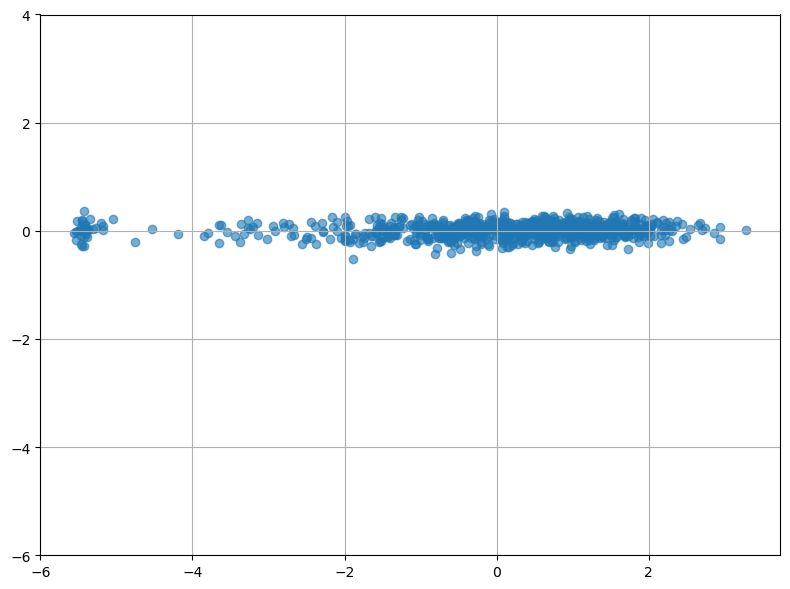

In [14]:
# Residuals = actual - predicted
residuals = Y_cattle_TEST - y_predm1v1

plt.figure(figsize=(8, 6))
plt.scatter(Y_cattle_TEST, y_predm1v1, alpha=0.6) # Y_cattle_TEST

#plt.xlabel("y_predm1v1 Values")
#plt.ylabel("Residuals (Actual - Predicted)")
#plt.title("Residuals vs. y_pred Values")
plt.ylim(-6, 4) 
plt.grid(True)
plt.tight_layout()
plt.show()


### Extract (Built-In) Feature Importance Scores

In [9]:
# Get feature importances from the best model
importances = random_forestm1v1.best_estimator_.feature_importances_

# Pair them with feature names and sort by importance
feature_names = X_cattle.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                                              Feature  Importance
3                                      age_constant_z    0.145279
5                                     number_minors_z    0.093334
4                                     number_adults_z    0.089826
2                                          owns_phone    0.038123
22  household_description_Partially settled: Some ...    0.033156
7                                      agric_land_Yes    0.032298
30  why_not_purchase_recoded_Lack of Awareness or ...    0.031708
26              religion_recoded_Traditional/Wakefata    0.031690
29  why_not_purchase_recoded_Financial, Practical,...    0.031352
24  main_info_source_recoded_Professional and Orga...    0.030319
27                                household_moved_Yes    0.027565
18                     activity_child_recoded_Student    0.027364
23  main_info_source_recoded_Media, Community-Base...    0.027293
0                                              expend    0.025521
25        

## Shap

### Investigate Shapely Values

In [54]:
labels = {
  "activity_child_recodedWorking": "Child's Activity: Working (Ref: House/Domestic Work)",
  "trust_vip_Yes" : "Trust in VIP (Ref: No)",
  "know_vip_Yes" : "Knows VIP (Ref: No)",
  "educ_recoded_constant_Elementary" : "Adult's Education: Elementary (Ref: Adult Education)",
  "agric_land_Yes" : "Owns Agricultural Land (Ref: No)",
  "activity_child_recoded_Student" : "Child's Activity: Student (Ref: House/Domestic Work)",
  "eng_language_Yes" : "English Language (Ref: No)",
  "why_not_purchase_recoded_Financial, Practical, and Situational Constraints" : "Reason Non-Purchase: Financial, Practical, and Situational Constraints (Ref: Bought Insurance)",
  "activity_child_recoded_Working with Livestock" : "Child's Activity: Livestock Work (Ref: House/Domestic Work)",
  "educ_recoded_constant_Nursery" : "Adult's Education: Nursery  (Ref: Adult Education)",
  "number_minors_z" : "Number of Minors in HH (z)",
  "number_adults_z" : "Number of Adults in HH (z)",
  "owns_phone" : "Owns Phone (Ref: No)",
  "religion_recoded_Traditional/Wakefata" : "Religion: Traditional/Wakefata (Ref: Christian)",
  "religion_recoded_Muslim" : "Religion: Muslim (Ref: Christian)",
  "main_info_source_recoded_Professional and Organizational Sources" : "Info Source: Professional and Organizational Sources (Ref: Interpersonal Sources)",
  "household_moved_Yes" : "Household Moved (Ref: No)",
  "why_not_purchase_recoded_Lack of Awareness or Understanding" : "Reason Non-Purchase: Lack of Awareness / Understanding (Ref: Bought Insurance)",
  "main_info_source_recoded_Media, Community-Based, and Survey Sources" : "Info Source: Media, Community-Based, and Survey Sources  (Ref: Interpersonal Sources)",
  "household_description_Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals" : "Household Partially Settled (Ref: Fully Settled)",
  "household_description_Not settled: The whole household moves around in order to herd the animals" : "Household Not Settled  (Ref: Fully Settled)",
  "age_constant_z" : "Age (z)",
  "educ_child_recoded_Never attended school" : "Child's Education: Never atteneded School (Ref: Elementary)",
  "expend" : "Expend (Ref: No)",
  "afm_language_Yes" : "Afm Language (Ref: No)",
  "amh_language_Yes" : "Amh Language (Ref: No)",
  "educ_recoded_constant_Never attended" : "Adult's Education: Never attended (Ref: Adult Education)",
  "activity_child_recoded_Not working" : "Child's Activity: Not Working (Ref: House/Domestic Work)",
  "educ_child_recoded_Secondary" : "Child's Education: Secondary School (Ref: Elementary)",
  "irrigated_land_bin" : "Irrigated Land (Ref: No)",
  "why_not_purchase_recoded_Distrust or Negative Perception" : "Reason Non-Purchase: Distrust or Negative Perception (Ref: Bought Insurance)",
  "educ_recoded_constant_Secondary and Higher" : "Adult's Education: Secondary and Higher (Ref: Adult Education)",
  "educ_child_recoded_Other" : "Child's Education: Other (Ref: Elementary)",
  "activity_child_recoded_Working" : "Child's Activity: Working (Ref: House/Domestic Work)",
}

c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


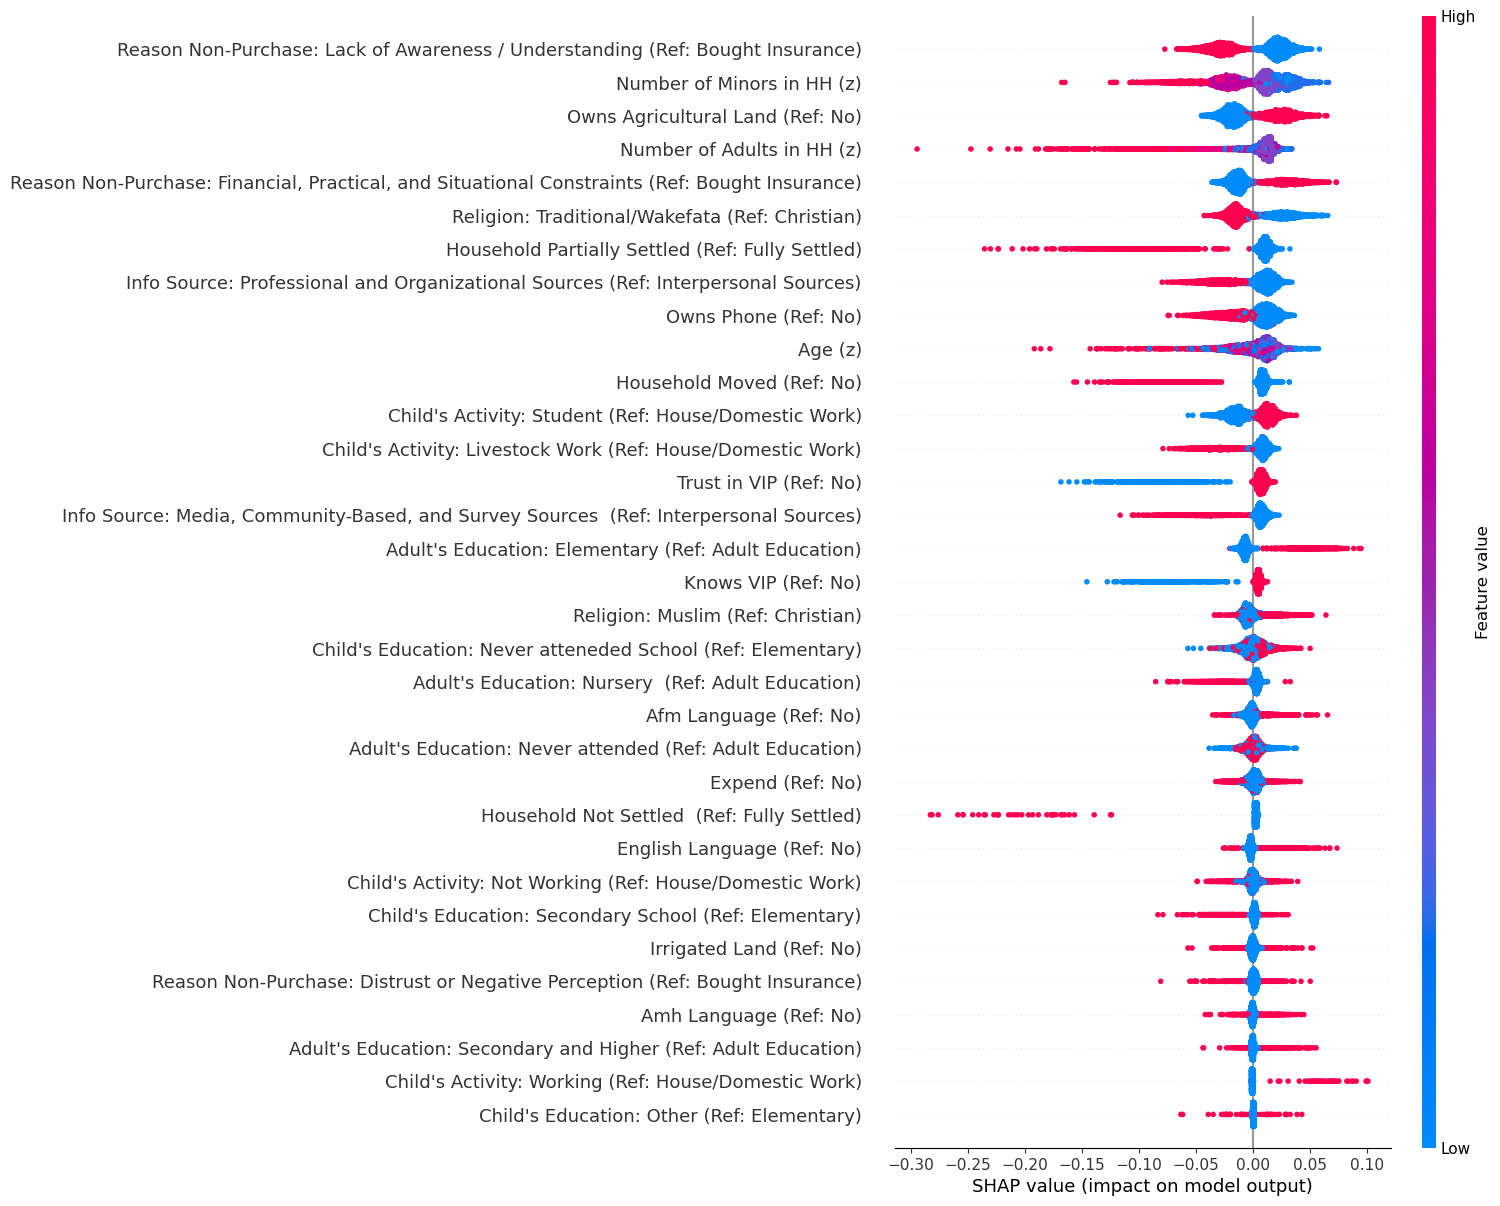

In [ ]:
# 1. Best model
best_model = random_forestm1v1.best_estimator_

# 2. Explainer
explainer = shap.TreeExplainer(best_model)

X_cattle_renamed = X_cattle.rename(columns=labels)

# 4. Compute SHAP values
shap_values = explainer.shap_values(X_cattle)

# 4. Plot SHAP summary with renamed columns
shap.summary_plot(
    shap_values,
    X_cattle_renamed,
    plot_type="dot",
    max_display=100
)

In [ ]:
# Compute mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Create DataFrame with feature names
shap_importance = pd.DataFrame({
    "Feature": X_cattle_renamed.columns,
    "Mean |SHAP value|": mean_abs_shap
}).sort_values(by="Mean |SHAP value|", ascending=False)  # sort ascending for horizontal bar chart

# Plot top 10 features
top_n = 10
top_features = shap_importance.head(top_n)
top_features

,Feature,Mean SHAP value
30,Reason Non-Purchase: Lack of Awareness / Under...,0.025739
5,Number of Minors in HH (z),0.024721
7,Owns Agricultural Land (Ref: No),0.020745
4,Number of Adults in HH (z),0.019090
29,"Reason Non-Purchase: Financial, Practical, and...",0.019011
26,Religion: Traditional/Wakefata (Ref: Christian),0.019003
22,Household Partially Settled (Ref: Fully Settled),0.018990
24,Info Source: Professional and Organizational S...,0.016979
2,Owns Phone (Ref: No),0.015795
3,Age (z),0.015603


c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


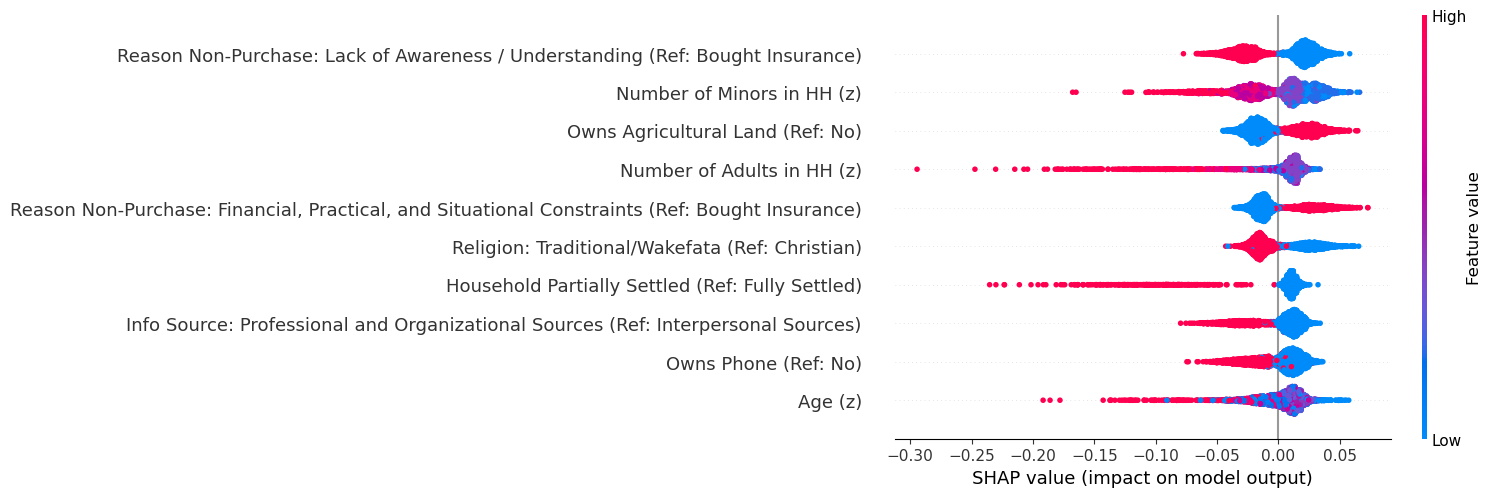

In [59]:
shap.summary_plot(
    shap_values,
    X_cattle_renamed,
    plot_type="dot",
    max_display=10
)

In [20]:
shap_interaction_values = explainer.shap_interaction_values(X_cattle)

In [49]:
# Get interaction strengths
interaction_strengths = np.abs(shap_interaction_values).mean(axis=0)
#np.fill_diagonal(interaction_strengths, 0)  # Remove main effects

# Convert to DataFrame
interaction_df = pd.DataFrame(
    interaction_strengths,
    index=X_cattle.columns,
    columns=X_cattle.columns
)

# Sort by most interactive partners with 'owns_phone'
interaction_df.head(5)

,expend,irrigated_land_bin,owns_phone,age_constant_z,number_adults_z,number_minors_z,afm_language_Yes,agric_land_Yes,amh_language_Yes,educ_recoded_constant_Elementary,educ_recoded_constant_Never attended,educ_recoded_constant_Nursery,educ_recoded_constant_Secondary and Higher,eng_language_Yes,educ_child_recoded_Never attended school,educ_child_recoded_Other,educ_child_recoded_Secondary,activity_child_recoded_Not working,activity_child_recoded_Student,activity_child_recoded_Working,activity_child_recoded_Working with Livestock,household_description_Not settled: The whole household moves around in order to herd the animals,household_description_Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals,"main_info_source_recoded_Media, Community-Based, and Survey Sources",main_info_source_recoded_Professional and Organizational Sources,religion_recoded_Muslim,religion_recoded_Traditional/Wakefata,household_moved_Yes,why_not_purchase_recoded_Distrust or Negative Perception,"why_not_purchase_recoded_Financial, Practical, and Situational Constraints",why_not_purchase_recoded_Lack of Awareness or Understanding,know_vip_Yes,trust_vip_Yes
expend,0.002340,0.000327,0.000600,0.000885,0.000864,0.000942,0.000992,0.001397,0.000210,0.000848,0.000851,0.000341,0.000138,0.000215,0.001111,0.000056,0.000201,0.000482,0.000668,0.000058,0.000532,0.000049,0.000326,0.000588,0.000734,0.000441,0.001104,0.000437,0.000193,0.001271,0.001126,0.000431,0.000482
irrigated_land_bin,0.000327,0.001294,0.000318,0.000656,0.000338,0.000597,0.000418,0.000746,0.000092,0.000167,0.000326,0.000102,0.000064,0.000124,0.000219,0.000007,0.000232,0.000276,0.000458,0.000022,0.000492,0.000032,0.000166,0.000656,0.000461,0.000361,0.000309,0.000398,0.000328,0.000838,0.000547,0.000161,0.000103
owns_phone,0.000600,0.000318,0.015791,0.001290,0.001513,0.001453,0.000618,0.002335,0.000451,0.000605,0.001096,0.000736,0.000311,0.000886,0.002491,0.000110,0.000469,0.001340,0.001969,0.000028,0.001860,0.000182,0.000534,0.000574,0.001711,0.000960,0.001184,0.000557,0.000441,0.001157,0.001579,0.000339,0.000492
age_constant_z,0.000885,0.000656,0.001290,0.013288,0.001155,0.001715,0.001052,0.001435,0.000372,0.001147,0.001137,0.000769,0.000296,0.000626,0.001678,0.000037,0.000273,0.001535,0.001240,0.000079,0.001707,0.000113,0.001529,0.000785,0.002230,0.001581,0.002087,0.001067,0.000325,0.001024,0.001491,0.000884,0.000570
number_adults_z,0.000864,0.000338,0.001513,0.001155,0.018567,0.001646,0.000692,0.001068,0.000185,0.000750,0.001139,0.000820,0.000102,0.000452,0.001419,0.000116,0.000446,0.000430,0.000782,0.000036,0.000777,0.000156,0.001187,0.001494,0.001480,0.000798,0.001168,0.000521,0.000667,0.001367,0.001169,0.000258,0.000675


In [ ]:
# Flatten upper triangle to get unique interaction pairs
interaction_pairs = (
    interaction_df.where(np.triu(np.ones(interaction_df.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
interaction_pairs.columns = ['Feature 1', 'Feature 2', 'Mean |Interaction SHAP|']

# Sort by strength
top_interactions = interaction_pairs.sort_values(by='Mean |Interaction SHAP|', ascending=False)

# Display top N
top_n = 10
top_interactions.head(top_n)


,Feature 1,Feature 2,Mean |Interaction SHAP|
497,main_info_source_recoded_Professional and Orga...,why_not_purchase_recoded_Lack of Awareness or ...,0.002783
74,owns_phone,educ_child_recoded_Never attended school,0.002491
360,educ_child_recoded_Never attended school,activity_child_recoded_Student,0.002395
67,owns_phone,agric_land_Yes,0.002335
496,main_info_source_recoded_Professional and Orga...,"why_not_purchase_recoded_Financial, Practical,...",0.002332
372,educ_child_recoded_Never attended school,why_not_purchase_recoded_Lack of Awareness or ...,0.002235
113,age_constant_z,main_info_source_recoded_Professional and Orga...,0.002230
368,educ_child_recoded_Never attended school,religion_recoded_Traditional/Wakefata,0.002115
115,age_constant_z,religion_recoded_Traditional/Wakefata,0.002087
78,owns_phone,activity_child_recoded_Student,0.001969


## Aggregate Dummy Variables to Original Categorical Feature

The absolute values are summed up to their original, broader variable. Absolute values are used so as to get the variables' strength and avoid positive and negative effects to cancel each other out.

In [70]:
# create mapping of dummies to variable
dummy_groups = {
    "Religion": ["Religion: Muslim (Ref: Christian)", "Religion: Traditional/Wakefata (Ref: Christian)"],
    "Adult's Education": ["Adult's Education: Elementary (Ref: Adult Education)", "Adult's Education: Never attended (Ref: Adult Education)", "Adult's Education: Nursery  (Ref: Adult Education)", "Adult's Education: Secondary and Higher (Ref: Adult Education)"],
    "Child's Education": ["Child's Education: Never atteneded School (Ref: Elementary)", "Child's Education: Other (Ref: Elementary)", "Child's Education: Secondary School (Ref: Elementary)"],
    "Child's Activity": ["Child's Activity: Not Working (Ref: House/Domestic Work)", "Child's Activity: Student (Ref: House/Domestic Work)", "Child's Activity: Working (Ref: House/Domestic Work)", "Child's Activity: Livestock Work (Ref: House/Domestic Work)"],
    "Household Status": ["Household Not Settled  (Ref: Fully Settled)", "Household Partially Settled (Ref: Fully Settled)"],
    "Main Information Source": ["Info Source: Media, Community-Based, and Survey Sources  (Ref: Interpersonal Sources)", "Info Source: Professional and Organizational Sources (Ref: Interpersonal Sources)"],
    "Reason Non-Purchase": ["Reason Non-Purchase: Financial, Practical, and Situational Constraints (Ref: Bought Insurance)", "Reason Non-Purchase: Lack of Awareness / Understanding (Ref: Bought Insurance)", 
                            "Reason Non-Purchase: Distrust or Negative Perception (Ref: Bought Insurance)"],
    "Trust in VIP": ["Trust in VIP (Ref: No)"],
    "Knows VIP": ["Knows VIP (Ref: No)"],
    "Expend" : ["Expend (Ref: No)"],
    "Irrigated Land": ["Irrigated Land (Ref: No)"],
    "Owns Phone": ["Owns Phone (Ref: No)"],
    "Afm Language": ["Afm Language (Ref: No)"],
    "Owns Agricultural Land" : ["Owns Agricultural Land (Ref: No)"],
    "Amh Language": ["Amh Language (Ref: No)"],
    "English Language": ["English Language (Ref: No)"],
    "Household Moved" : ["Household Moved (Ref: No)"]                             
}

# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_cattle_renamed.columns)

# Aggregate SHAP values by summing dummy columns
shap_agg = pd.DataFrame(index=shap_df.index)
for group_name, dummy_cols in dummy_groups.items():
    shap_agg[group_name] = shap_df[dummy_cols].abs().sum(axis=1)

# 4. Add remaining non-dummy columns
flattened_dummy_cols = [col for group in dummy_groups.values() for col in group]
non_dummy_cols = [col for col in shap_df.columns if col not in flattened_dummy_cols]
shap_agg[non_dummy_cols] = shap_df[non_dummy_cols]

### Aggregate SHAP values to get Overall Feature Importances

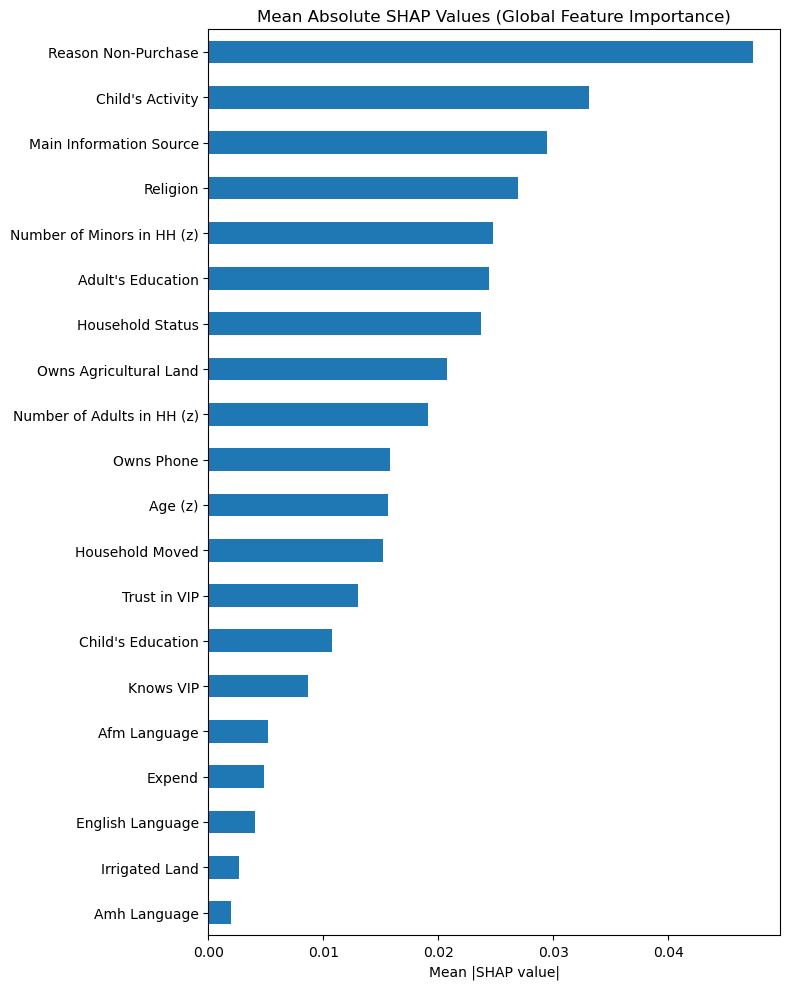

In [ ]:
# Create Mean SHAP values across datapoints, effectively: Overall Feature Importancess
feature_importance = pd.Series(
    np.abs(shap_agg).mean(axis=0),
    index=shap_agg.columns
).sort_values(ascending=True)

feature_importance.plot(kind='barh', figsize=(8, 10))
plt.title('Mean Absolute SHAP Values (Global Feature Importance)')
plt.xlabel('Mean |SHAP value|')
plt.tight_layout()
plt.show()

In [ ]:
# turn into dataframe, add column names and save
feature_importance = feature_importance.reset_index()
feature_importance.columns = ['feature', 'importance']

feature_importance
feature_importance.to_csv("feature_importance_randomforest_cattle.csv", header=True, index=False)

# Refit using Education Variables as Numeric Variables

Goal: By (slightly) reducing the number of categorical variables, and increasing the number of numeric variables, the R2 might be increased. 

In [17]:
# load train and test data (previously created in the ElasticNet notebook)
train_cattle = pd.read_csv("train_cattle_df.csv")
test_cattle = pd.read_csv("test_cattle_df.csv")

In [45]:
train_cattle.columns

Index(['id', 'wave', 'afm_language', 'age_constant', 'agric_land',
       'amh_language', 'educ_recoded_constant', 'educ_recoded_constant_num',
       'eng_language', 'expend', 'irrigated_land_bin',
       'cs_cs_diff_post_cattle', 'cs_cs_ratio_post_cattle', 'number_minors',
       'educ_child_recoded', 'educ_child_recodedNUMERIC',
       'activity_child_recoded', 'household_description', 'number_adults',
       'main_info_source_recoded', 'religion_recoded', 'owns_phone',
       'household_moved', 'why_not_purchase_recoded', 'know_vip', 'trust_vip',
       'age_constant_z', 'number_adults_z', 'number_minors_z', 'educ_child_z',
       'educ_adult_z', 'cs_diff_log', 'resid_mixed'],
      dtype='object')

In [18]:
# Prepare X and Y training sets for models
X_cattle = train_cattle.copy
X_cattle = train_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", "educ_recoded_constant", "educ_child_recoded",
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_cattle = train_cattle["resid_mixed"]

X_cattle_TEST = test_cattle.copy
X_cattle_TEST = test_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", "educ_recoded_constant", "educ_child_recoded",
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_cattle_TEST = test_cattle["resid_mixed"]

In [19]:
# Prepare categorical variables but creating dummies
X_cattle = pd.get_dummies(X_cattle, drop_first='True')
X_cattle_TEST = pd.get_dummies(X_cattle_TEST, drop_first='True')
X_cattle_TEST.columns

Index(['expend', 'irrigated_land_bin', 'owns_phone', 'age_constant_z',
       'number_adults_z', 'number_minors_z', 'educ_child_z', 'educ_adult_z',
       'afm_language_Yes', 'agric_land_Yes', 'amh_language_Yes',
       'eng_language_Yes', 'activity_child_recoded_Not working',
       'activity_child_recoded_Student', 'activity_child_recoded_Working',
       'activity_child_recoded_Working with Livestock',
       'household_description_Not settled: The whole household moves around in order to herd the animals',
       'household_description_Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals',
       'main_info_source_recoded_Media, Community-Based, and Survey Sources',
       'main_info_source_recoded_Professional and Organizational Sources',
       'religion_recoded_Muslim', 'religion_recoded_Traditional/Wakefata',
       'household_moved_Yes',
       'why_not_purchase_recoded_Distrust or Negative Perception',


In [ ]:
rf = RandomForestRegressor(random_state=0)

cv_params = {'max_depth': [5,7,10,15, None], 
             'min_samples_leaf': [2,4,6,8,10],
             'min_samples_split': [2,3,4,6,8,10],
             'max_features': [2,5,10,15],
             'n_estimators,': [50, 75, 100, 125, 150,200]
            }  

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

random_forestm2 = RandomizedSearchCV(
    estimator=rf,
    param_distributions=cv_params,
    n_iter=200,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

In [ ]:
%%time
#random_forestm2.fit(X_cattle, Y_cattle)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
CPU times: total: 7.77 s
Wall time: 1min 46s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=0), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 10, 15, None],
                                        'max_features': [2, 5, 10, 15],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 3, 4, 6, 8,
                                                              10],
                                        'n_estimators': [50, 75, 100, 125, 150,
                                                         200]},
                   refit='mse', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'random_forest_m2_CATTLEv1.pickle', 'wb') as to_write:
#    pickle.dump(random_forestm2, to_write)

In [26]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'random_forest_m2_CATTLEv1.pickle', 'rb') as to_read:
    random_forestm2v1 = pickle.load(to_read)

print("Best hyperparameters:\n", random_forestm2v1.best_params_ , "\n")
print("Performance based on best hyperparameter specification MSE:\n", random_forestm2v1.best_score_)

Best hyperparameters:
 {'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 5, 'max_depth': 5} 

Performance based on best hyperparameter specification MSE:
 -2.6605218463831166


In [27]:
# 3. Predict on the test set
y_predm2v1 = random_forestm2v1.predict(X_cattle_TEST)

# 4. Evaluate performance
mae = mean_absolute_error(Y_cattle_TEST, y_predm2v1)
mse = mean_squared_error(Y_cattle_TEST, y_predm2v1)
r2  = r2_score(Y_cattle_TEST, y_predm2v1)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.1852
Root Mean Squared Error (RMSE):  1.6482
R-squared (R²):            0.0071


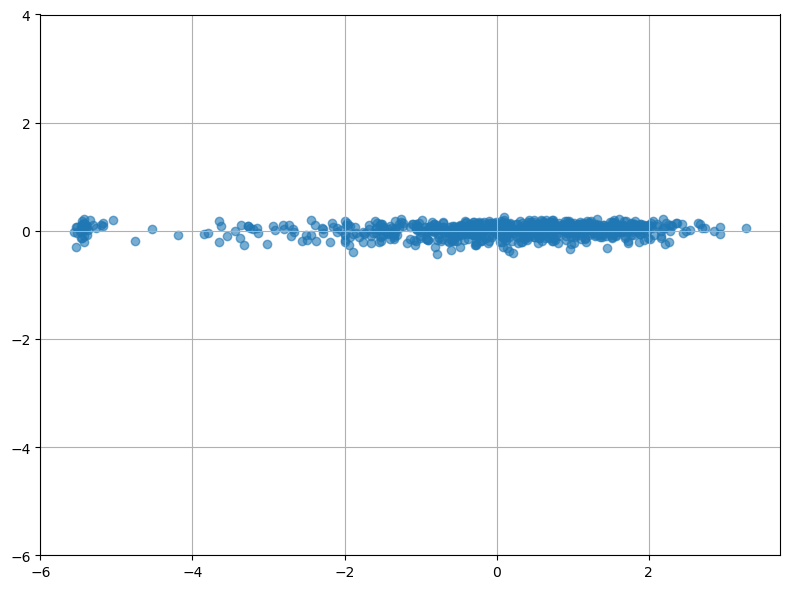

In [29]:
# Residuals = actual - predicted
residuals = Y_cattle_TEST - y_predm2v1

plt.figure(figsize=(8, 6))
plt.scatter( Y_cattle_TEST, y_predm2v1, alpha=0.6) # Y_cattle_TEST

#plt.xlabel("y_predm1v1 Values")
#plt.ylabel("Residuals (Actual - Predicted)")
#plt.title("Residuals vs. y_pred Values")
plt.ylim(-6, 4) 
plt.grid(True)
plt.tight_layout()
plt.show()
